## 3.1

### Ridge regression

In [2]:
from ridge_regression import *
from setup_problem import load_problem


In [3]:
# load problem and split data
lasso_data_fname = "lasso_data.pickle"
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

# Generate features
X_train = featurize(x_train)
X_val = featurize(x_val)

In [4]:
# do grid search between the interval 10-3 to 10-1
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))
val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation
param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                        np.arange(1,3,.3)
                                            ))) }]


ridge_regression_estimator = RidgeRegression()
grid = GridSearchCV(ridge_regression_estimator,
                param_grid,
                return_train_score=True,
                cv = PredefinedSplit(test_fold=val_fold),
                refit = True,
                scoring = make_scorer(mean_squared_error,
                                        greater_is_better = False))
grid.fit(X_train_val, y_train_val)

df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow = df_toshow.sort_values(by=["param_l2reg"])
results = df_toshow

print(results)

param_l2reg  mean_test_score  mean_train_score
0        0.0200         0.139470          0.048579
1        0.0205         0.139444          0.049196
2        0.0210         0.139423          0.049802
3        0.0215         0.139408          0.050395
4        0.0220         0.139395          0.050979
5        0.0225         0.139387          0.051553
6        0.0230         0.139381          0.052116
7        0.0235         0.139379          0.052670
8        0.0240         0.139381          0.053213
9        0.0245         0.139384          0.053749
10       0.0250         0.139390          0.054276
11       0.0255         0.139399          0.054794
12       0.0260         0.139411          0.055304
13       0.0265         0.139424          0.055806
14       0.0270         0.139439          0.056303
15       0.0275         0.139456          0.056790
16       0.0280         0.139474          0.057270
17       0.0285         0.139494          0.057743
18       0.0290         0.139515   

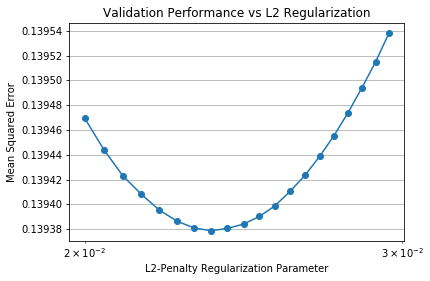

In [5]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(results["param_l2reg"], results["mean_test_score"],'-o')
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
fig.show()

In [6]:
# lamda that minimized the empirical risk on the validation set
l2reg_opt = results['param_l2reg'][np.argmin(results['mean_test_score'])]

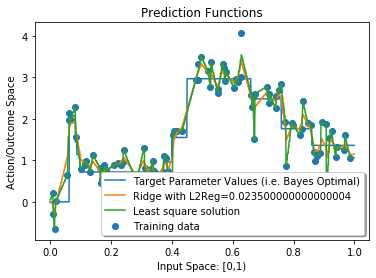

In [7]:
# Let's plot prediction functions and compare coefficients for several fits
	# and the target function.
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })
X = featurize(x)
# regress with l2reg-opt
ridge_regression_estimator = RidgeRegression(l2reg=l2reg_opt)
ridge_regression_estimator.fit(X_train, y_train)
name = "Ridge with L2Reg="+str(l2reg_opt)
pred_fns.append({"name":name,
                    "coefs":ridge_regression_estimator.w_,
                    "preds": ridge_regression_estimator.predict(X) })
# least square
w_ls = np.linalg.pinv((X_train.T@X_train))@X_train.T@y_train
name = "Least square solution"
pred_fns.append({"name":name,
                    "coefs":w_ls,
                    "preds": X@w_ls })
f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
f.show()


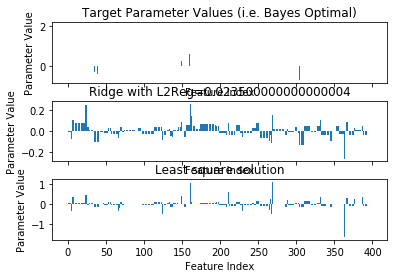

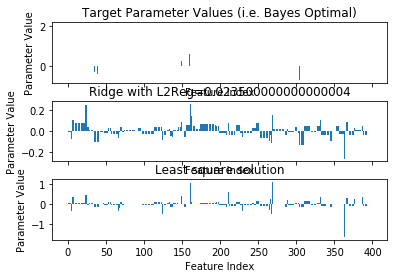

In [8]:
compare_parameter_vectors(pred_fns)

In terms of the scale of the coefficients, ridge regression apparently leads to the smallest scale compared to both the target and the LS solution. Moreover, the patterns of the coefficients yielded by ridge regression and LS look pretty alike, although with ridge regression the peaks are supressed. Ridge regression can certainly prevent wrong estimates from going too dominant, while at the same also suppressing those more accurate results.

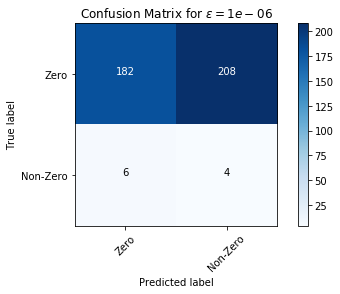

In [9]:
w_ridge = ridge_regression_estimator.w_
w_true = coefs_true
eps = 1e-6

mask_ridge = np.zeros_like(w_ridge,dtype=np.int)
mask_ridge += (w_ridge>eps)*1

mask_true = np.zeros_like(w_true,dtype=np.int)
mask_true += (w_true!=0)*1

cnf_matrix = confusion_matrix(mask_true, mask_ridge)
plt.figure()
plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])
plt.show()

### Lasso Regression

In [4]:
import numpy as np
from functools import partial

In [ ]:
def lasso_objective(X,Y,lambda_,w,aug=False):
    obj_residual = np.dot(X,w)-Y
    L = np.dot(obj_residual,obj_residual)+lambda_*np.sum(np.abs(w if not aug else w[:-1]))

    return L

In [88]:
def shooting(X,Y,lambda_,w_0,eps=1e-8,obj_func = lasso_objective,mode='cyclic',aug=False):
    D = X.shape[1]
    w = w_0.copy()
    L = partial(obj_func,X,Y,lambda_)
    L_pre = 0
    count = 0
    while L_pre-L(w) > eps or count == 0:
        L_pre = L(w)
        count += 1
        if mode == 'cyclic':
            order = np.arange(D)
        elif mode == 'random':
            order = np.random.permutation(D)

        for j in order:
            Xj = X[:,j]
            aj = 2*np.dot(Xj,Xj)
            res = Y - np.dot(X,w) + w[j]*Xj
            cj = 2*np.dot(Xj,res)
            if aj == 0:
                w[j] = 0
            else:
                if (j == len(order)-1) and aug:
                    w[j] = np.sign(cj)*np.abs(cj/aj)
                else:
                    w[j] = np.sign(cj)*np.clip(np.abs(cj/aj)-lambda_/aj,a_min=0,a_max=None)
    
    print('Condition(s) fulfilled. L={}, L_pre-L={}, count={}\n'.format(L(w),L_pre-L(w),count))
    return w

In [13]:
w0 = ridge_regression_estimator.w_.copy()
l = 0.1
w = shooting(X_train,y_train,l,w0,mode='random')
val_e = lasso_objective(X_val,y_val,0,w)
print('validation loss: {}'.format(val_e))

Condition(s) fulfilled. L=3.904974228348668, L_pre-L=9.988085913903433e-09, count=1090

validation loss: 142.2136613297223


In [14]:
w0 = ridge_regression_estimator.w_.copy()
l = 0.1
w = shooting(X_train,y_train,l,w0,mode='cyclic')
val_e = lasso_objective(X_val,y_val,0,w)
print('validation loss: {}'.format(val_e))

Condition(s) fulfilled. L=3.9049739209576786, L_pre-L=9.895796182490812e-09, count=1193

validation loss: 142.0037878454513


In [15]:
w0 = np.zeros_like(ridge_regression_estimator.w_)
l = 0.1
w = shooting(X_train,y_train,0.1,w0,mode='random')
val_e = lasso_objective(X_val,y_val,0,w)
print('validation loss: {}'.format(val_e))

Condition(s) fulfilled. L=3.904974343033722, L_pre-L=9.440494164181246e-09, count=1589

validation loss: 141.18585205412785


In [16]:
w0 = np.zeros_like(ridge_regression_estimator.w_)
l = 0.1
w = shooting(X_train,y_train,0.1,w0,mode='cyclic')
val_e = lasso_objective(X_val,y_val,0,w)
print('validation loss: {}'.format(val_e))

Condition(s) fulfilled. L=3.9049740755458315, L_pre-L=9.899884911845902e-09, count=1147

validation loss: 185.5217427736988


### Warm starting with last solution (homotopy)

In [67]:
l_max = 2*np.max(np.abs(np.dot(X_train.T,y_train)))
alpha = 0.8
l = l_max
w = np.zeros(X_train.shape[1])
w_list_homo = []
l_list_homo = []
vale_list_homo = []
while l > 1e-3:
    val_e = lasso_objective(X_val,y_val,0,w)
    w_list_homo.append(w)
    l_list_homo.append(l)
    vale_list_homo.append(val_e)
    print('lambda:{}. Val loss: {}'.format(l,val_e))
    w = shooting(X_train,y_train,l,w,mode='random')
    l = alpha*l

lambda:327.28283232952117. Val loss: 3218.897640878414
Condition(s) fulfilled. L=359.6674002813196, L_pre-L=0.0, count=1

lambda:261.8262658636169. Val loss: 3218.897640878414
Condition(s) fulfilled. L=348.52108680765144, L_pre-L=9.844995929597644e-09, count=312

lambda:209.46101269089354. Val loss: 2325.2509510737345
Condition(s) fulfilled. L=323.5371647946133, L_pre-L=9.209657036990393e-09, count=221

lambda:167.56881015271483. Val loss: 1752.3945925642092
Condition(s) fulfilled. L=293.22926468659637, L_pre-L=6.467985258495901e-09, count=213

lambda:134.05504812217188. Val loss: 1379.678158940088
Condition(s) fulfilled. L=262.23637337491465, L_pre-L=9.861082617135253e-09, count=235

lambda:107.2440384977375. Val loss: 1100.388590991706
Condition(s) fulfilled. L=231.3036468468049, L_pre-L=9.685891200206243e-09, count=121

lambda:85.79523079819. Val loss: 825.1058340066659
Condition(s) fulfilled. L=202.0174852240021, L_pre-L=9.056492444869946e-09, count=113

lambda:68.63618463855201. V

In [68]:
w_list_homo = w_list_homo[::-1]
l_list_homo = l_list_homo[::-1]
vale_list_homo = vale_list_homo[::-1]

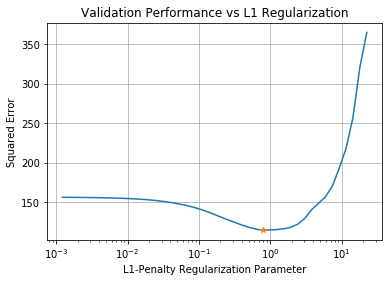

In [69]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(l_list_homo[:int(len(l_list_homo)//1.25)], vale_list_homo[:int(len(l_list_homo)//1.25)],'-')
min_idx = np.argmin(np.array(vale_list_homo)).item()
ax.semilogx([l_list_homo[min_idx]],[vale_list_homo[min_idx]],'*')
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Squared Error")
fig.show()

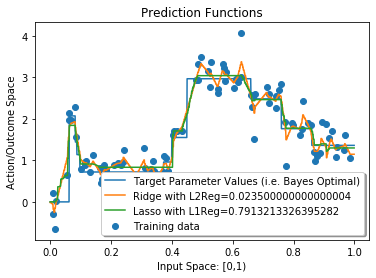

In [70]:
# Let's plot prediction functions and compare coefficients for several fits
	# and the target function.
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })
X = featurize(x)
# regress with l2reg-opt
ridge_regression_estimator = RidgeRegression(l2reg=l2reg_opt)
ridge_regression_estimator.fit(X_train, y_train)
name = "Ridge with L2Reg="+str(l2reg_opt)
pred_fns.append({"name":name,
                    "coefs":ridge_regression_estimator.w_,
                    "preds": ridge_regression_estimator.predict(X) })
# least square
w_l1 = w_list_homo[min_idx]
name = "Lasso with L1Reg={}".format(l_list_homo[min_idx])
pred_fns.append({"name":name,
                    "coefs":w_l1,
                    "preds": np.dot(X,w_l1) })
f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
f.show()


### warm satrting with ridge solution

In [71]:
l_max = 2*np.max(np.abs(np.dot(X_train.T,y_train)))
alpha = 0.8
l = l_max
w0 = ridge_regression_estimator.w_.copy()
w = w0
w_list = []
l_list = []
vale_list = []
while l > 1e-3:
    val_e = lasso_objective(X_val,y_val,0,w)
    w_list.append(w)
    l_list.append(l)
    vale_list.append(val_e)
    print('lambda:{}. Val loss: {}'.format(l,val_e))
    w = shooting(X_train,y_train,l,w0,mode='random')
    l = alpha*l

lambda:327.28283232952117. Val loss: 125.44094501703472
Condition(s) fulfilled. L=359.6674002813196, L_pre-L=0.0, count=3

lambda:261.8262658636169. Val loss: 3218.897640878414
Condition(s) fulfilled. L=348.5210866088406, L_pre-L=7.774076493660687e-09, count=405

lambda:209.46101269089354. Val loss: 2323.51077743741
Condition(s) fulfilled. L=323.53716463113193, L_pre-L=8.724384770175675e-09, count=282

lambda:167.56881015271483. Val loss: 1749.1693198763005
Condition(s) fulfilled. L=293.22926472151846, L_pre-L=9.504560694040265e-09, count=286

lambda:134.05504812217188. Val loss: 1376.5524037974687
Condition(s) fulfilled. L=262.23637334947875, L_pre-L=9.848463378148153e-09, count=369

lambda:107.2440384977375. Val loss: 1098.0507624033214
Condition(s) fulfilled. L=231.30364715345513, L_pre-L=7.396266710202326e-09, count=464

lambda:85.79523079819. Val loss: 822.6849144402039
Condition(s) fulfilled. L=202.01748559682864, L_pre-L=9.33744104258949e-09, count=412

lambda:68.63618463855201.

In [72]:
w_list = w_list[::-1]
l_list = l_list[::-1]
vale_list = vale_list[::-1]

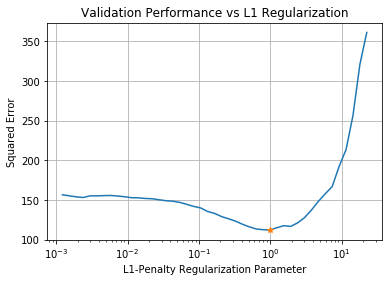

In [73]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(l_list[:int(len(l_list)//1.25)], vale_list[:int(len(l_list)//1.25)],'-')
min_idx = np.argmin(np.array(vale_list)).item()
ax.semilogx([l_list[min_idx]],[vale_list[min_idx]],'*')
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Squared Error")
fig.show()

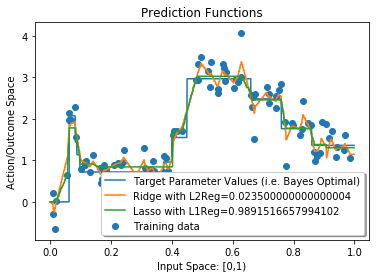

In [75]:
# Let's plot prediction functions and compare coefficients for several fits
	# and the target function.
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })
X = featurize(x)
# regress with l2reg-opt
ridge_regression_estimator = RidgeRegression(l2reg=l2reg_opt)
ridge_regression_estimator.fit(X_train, y_train)
name = "Ridge with L2Reg="+str(l2reg_opt)
pred_fns.append({"name":name,
                    "coefs":ridge_regression_estimator.w_,
                    "preds": ridge_regression_estimator.predict(X) })
# least square
w_l1 = w_list[min_idx]
name = "Lasso with L1Reg={}".format(l_list[min_idx])
pred_fns.append({"name":name,
                    "coefs":w_l1,
                    "preds": np.dot(X,w_l1) })
f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
f.show()


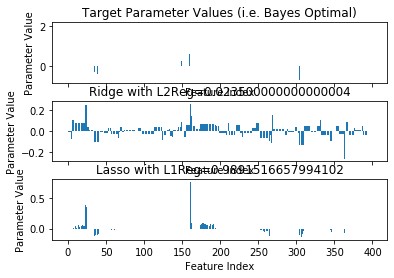

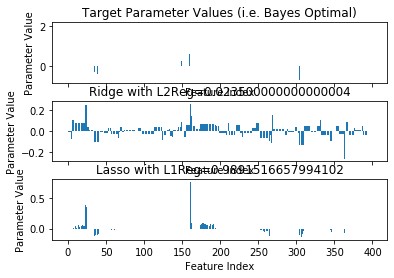

In [76]:
compare_parameter_vectors(pred_fns)

## 3.1 Optional

#### Lasso

In [91]:
y_centered = y_train - y_train.mean()
l_max = 2*np.max(np.abs(np.dot(X_train.T,y_centered)))
alpha = 0.8
l = l_max
w = np.zeros(X_train.shape[1])
w_list_homo = []
l_list_homo = []
vale_list_homo = []
while l > 1e-2:
    val_e = lasso_objective(X_val,y_val-y_val.mean(),0,w)
    w_list_homo.append(w)
    l_list_homo.append(l)
    vale_list_homo.append(val_e)
    print('lambda:{}. Val loss: {}'.format(l,val_e))
    w = shooting(X_train,y_centered,l,w,mode='random')
    l = alpha*l

lambda:66.51995371985255. Val loss: 849.9790319614905
Condition(s) fulfilled. L=94.35424556084892, L_pre-L=-1.4210854715202004e-14, count=1

lambda:53.21596297588204. Val loss: 849.9790319614905
Condition(s) fulfilled. L=93.5588616886107, L_pre-L=8.452559541183291e-09, count=346

lambda:42.572770380705634. Val loss: 779.0670809560677
Condition(s) fulfilled. L=91.73582189083247, L_pre-L=6.7817182980434154e-09, count=2

lambda:34.05821630456451. Val loss: 731.5868712785593
Condition(s) fulfilled. L=89.50795765287899, L_pre-L=6.1407661178236594e-09, count=301

lambda:27.24657304365161. Val loss: 702.5301169900191
Condition(s) fulfilled. L=86.3966256973299, L_pre-L=8.609916335444723e-09, count=416

lambda:21.79725843492129. Val loss: 600.6338653227554
Condition(s) fulfilled. L=81.74963333683309, L_pre-L=9.172097747978114e-09, count=433

lambda:17.43780674793703. Val loss: 487.0990003829115
Condition(s) fulfilled. L=75.37309613198602, L_pre-L=9.519453669781797e-09, count=453

lambda:13.9502

KeyboardInterrupt: 

In [93]:
X_train_aug = np.concatenate((X_train,np.ones((X_train.shape[0],1))),axis=1)
X_val_aug = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
l_max = 2*np.max(np.abs(np.dot(X_train_aug.T,y_train-y_train.mean())))
alpha = 0.8
l = l_max
w = np.zeros(X_train_aug.shape[1])
w_list_homo = []
l_list_homo = []
vale_list_homo = []
while l > 1e-2:
    val_e = lasso_objective(X_val_aug,y_val,0,w)
    w_list_homo.append(w)
    l_list_homo.append(l)
    vale_list_homo.append(val_e)
    print('lambda:{}. Val loss: {}'.format(l,val_e))
    w = shooting(X_train_aug,y_train,l,w,mode='random',aug=True)
    l = alpha*l

lambda:66.51995371985255. Val loss: 3218.897640878414
Condition(s) fulfilled. L=186.11509491197518, L_pre-L=-3.5489747590162324, count=4

lambda:53.21596297588204. Val loss: 619.1243063040864
Condition(s) fulfilled. L=165.5539624357786, L_pre-L=-2.0511270323792132, count=1

lambda:42.572770380705634. Val loss: 550.2099367098348
Condition(s) fulfilled. L=144.40454604950992, L_pre-L=-0.878242389523507, count=2

lambda:34.05821630456451. Val loss: 566.5359671541391
Condition(s) fulfilled. L=126.51302777189632, L_pre-L=-0.017433226413274383, count=8

lambda:27.24657304365161. Val loss: 516.2649915729062
Condition(s) fulfilled. L=110.38520055233406, L_pre-L=-8.339794095491015e-05, count=27

lambda:21.79725843492129. Val loss: 464.3787396467078
Condition(s) fulfilled. L=97.50731195871617, L_pre-L=-0.006628021189243327, count=12

lambda:17.43780674793703. Val loss: 392.2965527384895
Condition(s) fulfilled. L=85.76061830452272, L_pre-L=-0.005939162618673777, count=17

lambda:13.950245398349626

Having an unregularized bias terms significantly speeds up the convergence of the shooting algorithm at each $\lambda$. But the introduction of an unregularized term undermines the performance in a way, for it tends to be learnt to overfit the training data. 

In [7]:
# do grid search between the interval 10-3 to 10-1
X_train_val = np.vstack((X_train, X_val))
y_train_val = np.concatenate((y_train-y_train.mean(), y_val-y_val.mean()))
val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation
param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,1),
                                        np.arange(1,3,.3)
                                            ))) }]

ridge_regression_estimator = RidgeRegression()
grid = GridSearchCV(ridge_regression_estimator,
                param_grid,
                return_train_score=True,
                cv = PredefinedSplit(test_fold=val_fold),
                refit = True,
                scoring = make_scorer(mean_squared_error,
                                        greater_is_better = False))
grid.fit(X_train_val, y_train_val)

df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow = df_toshow.sort_values(by=["param_l2reg"])
results = df_toshow

print(results)

param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.178923          0.006752
1      0.000010         0.178809          0.006752
2      0.000100         0.177703          0.006773
3      0.001000         0.169136          0.008264
4      0.010000         0.148593          0.032714
5      0.100000         0.168841          0.112772
6      1.000000         0.268280          0.263542
7      1.300000         0.283199          0.282292
8      1.600000         0.296464          0.298239
9      1.900000         0.308748          0.312516
10     2.200000         0.320357          0.325676
11     2.500000         0.331455          0.338013
12     2.800000         0.342133          0.349706


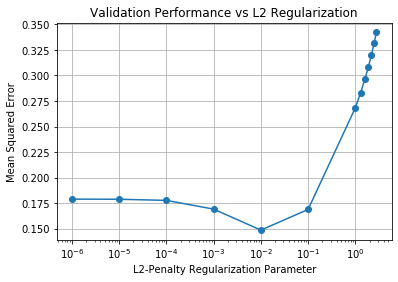

In [8]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots()
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
ax.semilogx(results["param_l2reg"], results["mean_test_score"],'-o')
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
fig.show()